In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
import pickle 

## Load data

In [3]:
df = pd.read_csv('irritation_MACCS.csv')
df.head(5)

,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,Class
0,54.046950,54.092,0.0,0.0,0.0,0.0,0.0,4.0,10.0,0.0,...,1.250000,0.250000,0.250000,0.0,-0.44,3.56,2.56,1.56,2.278400,1
1,56.062600,56.108,0.0,0.0,1.0,0.0,0.0,4.0,12.0,0.0,...,1.523603,0.288675,0.288675,0.0,-0.26,3.74,2.74,1.74,2.561900,1
2,58.005479,58.036,2.0,0.0,1.0,0.0,2.0,4.0,6.0,2.0,...,0.804738,0.055556,0.055556,0.0,-0.66,3.34,2.34,1.34,1.953900,1
3,58.041865,58.080,1.0,0.0,1.0,0.0,1.0,4.0,10.0,1.0,...,1.351057,0.166667,0.166667,0.0,-0.33,3.67,2.67,1.67,2.449725,1
4,59.017127,59.043,1.0,0.0,0.0,0.0,1.0,4.0,6.0,2.0,...,0.844421,0.059761,0.059761,0.0,-0.58,3.42,2.42,1.42,2.069100,1


### Split data into predictor and target

In [4]:
x = np.array(df.iloc[0:5220, 0:43])
y = np.array(df[['Class']]).ravel()

In [5]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
clf = GradientBoostingClassifier(random_state=10)
clf.fit(xtrain, ytrain)

GradientBoostingClassifier(random_state=10)

In [7]:
clf.score(xtrain, ytrain)

0.9547413793103449

In [8]:
ypred = clf.predict(xtest)

In [9]:
f1 = f1_score(ytest, ypred)
print(f1)

0.9495851946394385


### Hyperparameter optimization

In [11]:
from sklearn.model_selection import GridSearchCV

In [16]:
parameters = {
    "learning_rate": [0.01, 0.1, 0.2],
    "min_samples_leaf": [1, 5, 10],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 1.0],
    }

In [17]:
opt_clf = GridSearchCV(GradientBoostingClassifier(random_state=10), parameters, cv=10, n_jobs=-1)

In [18]:
opt_clf.fit(xtrain, ytrain)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'subsample': [0.5, 1.0]})

In [19]:
opt_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'subsample': 0.5}

In [23]:
opt_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features='log2', min_samples_leaf=5, subsample=0.5, random_state=10).fit(xtrain, ytrain)

In [24]:
opt_model.score(xtrain, ytrain)

0.9736590038314177

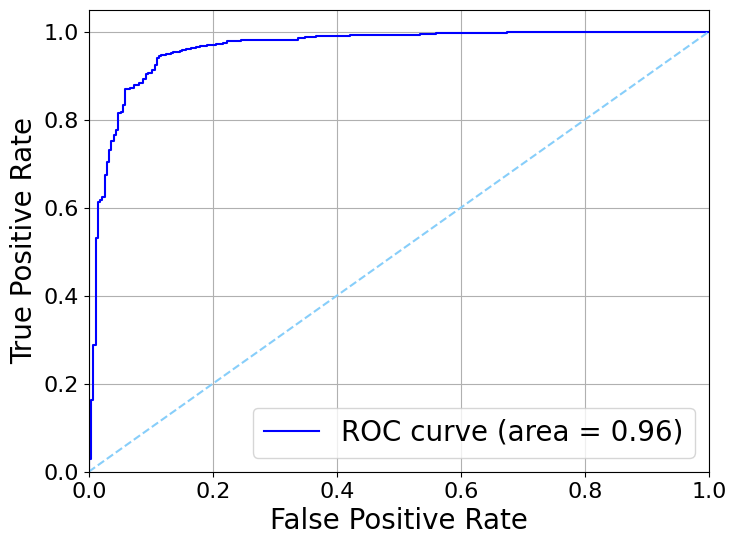

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split



# Predict probabilities for the test set
y_pred = opt_model.predict_proba(xtest)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='#87CEFA', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc='lower right', fontsize = 20)

# Set larger font size for tick labels
plt.tick_params(axis='both', labelsize=16)

plt.grid()
plt.savefig('irr_ML.svg', dpi=700, bbox_inches='tight')
plt.show()

In [12]:
importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': df.iloc[0:5220, 0:43].columns, 'Importance': importance})

feature_importance_df

,Feature,Importance
0,exactmw,0.000619
1,amw,0.001046
2,lipinskiHBA,0.004678
3,lipinskiHBD,0.005003
4,NumRotatableBonds,0.006219
5,NumHBD,0.006857
6,NumHBA,0.004270
7,NumHeavyAtoms,0.157011
8,NumAtoms,0.001638
9,NumHeteroatoms,0.015043


In [13]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
filtered_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.03]

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_24848\3189182547.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')


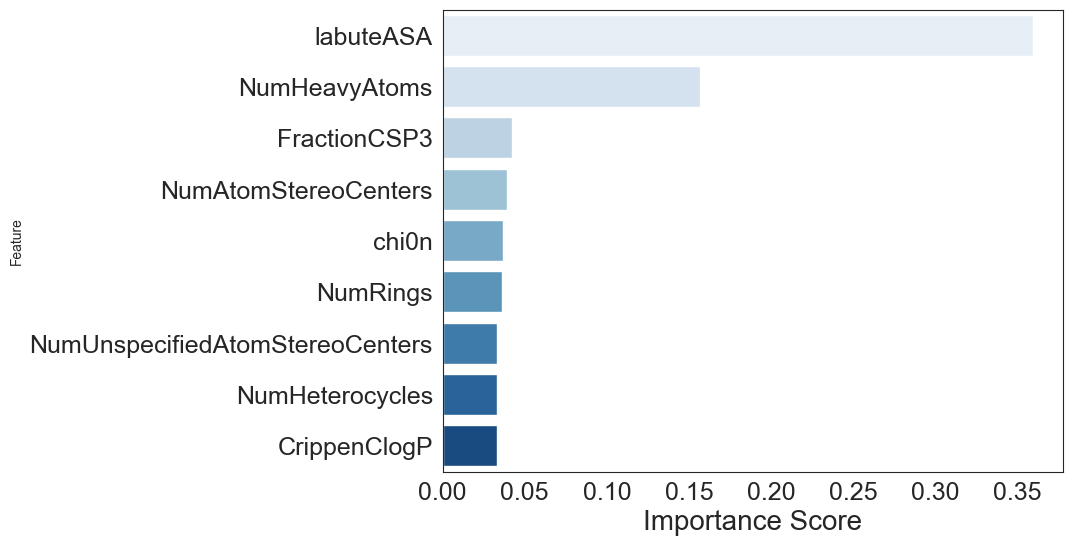

In [22]:
import matplotlib.pyplot as pyplot
import seaborn as sns
# Plot the feature importances
sns.set_style("white")

pyplot.figure(figsize=(8, 6))


sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')
sns.set_style("whitegrid")
pyplot.xlabel('Importance Score', fontsize = 20)

# Increase font size for tick labels
plt.tick_params(axis='both', labelsize=18)
pyplot.savefig('FI_irr.svg', dpi=700)
pyplot.show()

In [17]:
f1 = [0.923117616468313, 0.9502551020408163, 0.9502551020408163, 0.9502551020408163, 0.9502551020408163]
mean_f1 = np.mean(f1)
mean_f1

0.9448276049263156

In [18]:
std_f1 = np.std(f1)
std_f1

0.010854994229001312

In [16]:
acc = [0.9547413793103449, 0.9547413793103449, 0.9547413793103449, 0.9547413793103449, 0.9547413793103449]
mean_acc = np.mean(acc)
mean_acc

0.9547413793103449

In [17]:
std_acc = np.std(acc)
std_acc

0.0

## Case study

### Load generated SMILES

In [15]:
smiles = pd.read_csv('witn_ML_100.csv')
smiles

,Smiles
0,O=C(O)Cc1c(O)cccc1S(=O)(=O)NCOC(=O)Oc1ccccc1
1,O=CNC(c1ccccc1)c1cc(NCc2c[nH]c3ccccc23)cc(CC(=...
2,CC(CNN)c1cc(C2CCOC2c2ccncc2)ccc1CC(=O)O
3,CC(C)(N)C(C(=O)O)c1ccc(NC=S)c(NCC(=O)N[SH](=O)...
4,COCC(C(=O)O)c1ccc(C(N)c2c[nH]c3ccccc23)cc1[NH+...
...,...
2295,C=Cc1cc(NN)c(CC(=O)O)c(C(F)(F)F)c1-c1ccccc1N
2296,O=C(O)Cc1cc(CC(F)(F)F)c(-c2ccccn2)c(Oc2ccccc2)c1
2297,C=Cc1c(Nc2ccccc2)cc(CC(=O)O)c(C(F)(F)F)c1NN
2298,C=Cc1cc(O)c(C=N)c(CC(=O)O)c1-c1ccccn1


In [16]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

### Convert SMILES to RDKit descriptors

In [17]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

get_descriptors = rdMolDescriptors.Properties(descriptor_names)

def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

In [18]:
smiles['Smiles'] = smiles['Smiles'].apply(smi_to_descriptors)
smiles

,Smiles
0,"[381.05183744, 381.36200000000014, 9.0, 3.0, 7..."
1,"[498.22670543999993, 498.58300000000037, 8.0, ..."
2,"[355.18959165999996, 355.4380000000001, 6.0, 4..."
3,"[388.08751173999997, 388.4710000000001, 9.0, 6..."
4,"[538.30641856009, 538.7120000000003, 6.0, 5.0,..."
...,...
2295,"[351.119461412, 351.3280000000001, 5.0, 6.0, 5..."
2296,"[387.108228032, 387.3570000000001, 4.0, 1.0, 6..."
2297,"[351.1194614120001, 351.328, 5.0, 5.0, 6.0, 4...."
2298,"[282.100442308, 282.299, 5.0, 3.0, 5.0, 3.0, 4..."


In [19]:
X = np.stack(smiles.Smiles.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X

array([[381.05183744, 381.362     ,   9.        , ...,   8.31724518,
          5.19373676,   6.14767885],
       [498.22670544, 498.583     ,   8.        , ...,  11.17776377,
          5.43918524,   7.37033709],
       [355.18959166, 355.438     ,   6.        , ...,   8.40049869,
          4.09485429,   5.98027466],
       ...,
       [351.11946141, 351.328     ,   5.        , ...,   7.26643599,
          4.10005408,   5.33073436],
       [282.10044231, 282.299     ,   5.        , ...,   6.0026071 ,
          2.81333182,   4.13291655],
       [376.19106888, 376.432     ,   7.        , ...,   8.47321898,
          3.94886618,   6.05247114]])

### Calculate probability ob being toxic for all generated molecules

In [20]:
irritation = clf.predict_proba(X)[:, 1]
irritation

array([0.3902213 , 0.02138722, 0.0146964 , ..., 0.46534823, 0.20609046,
       0.01854351])

In [21]:
irritation_mean = np.mean(irritation)
irritation_mean

0.1815800768122784

### Save model

In [26]:
pkl_filename = "pickle_model_irritation.pkl"

In [27]:
with open(pkl_filename, 'wb') as file: 
    pickle.dump(opt_model, file)